# About

This notebook helps you to create your first solution and the first submisson file. Fill free to modify this notebook to create you own solution.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
from tqdm import tqdm
import seaborn as sns

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

In [26]:
# Change this according to your directory preferred setting
path_to_train = "data/train_1"
path_to_test = "data/test"

# This event is in Train_1
event_prefix = "event000001000"

### Train

Lets combine several events into single sample to train the classifier.

In [112]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

def get_training_sample(path_to_data, event_names):

    events = []
    track_id = 0

    for name in tqdm(event_names):
        # if there is an error skip it
        try:
            # Read an event
            hits, cells, particles, truth = load_event(os.path.join(path_to_data, name))

            # Generate new vector of particle id
            particle_ids = truth.particle_id.values
            particle2track = {}
            for pid in np.unique(particle_ids):
                particle2track[pid] = track_id
                track_id += 1
            hits['particle_id'] = [particle2track[pid] for pid in particle_ids]

            # Collect hits
            events.append(hits)
        except:
            print("Error with", name)
            continue
            
    # Put all hits into one sample with unique track ids
    data = pd.concat(events, axis=0)

    return data

def get_test_sample(path_to_test, event_ids = ['000000000']):
    events = []
    for event_id in event_ids:
        hits  = pd.read_csv(path_to_test + '/event%s-hits.csv'%event_id)
        truth = pd.read_csv('%s.dbscan_outliers_tuned.csv.gz'%event_id, compression='gzip')
        hits['event_id'] = event_id
        hits['particle_id'] = truth.track_id
        
        events.append(hits)
    data = pd.concat(events, axis=0)
    return data

In [125]:
test_data = get_test_sample(path_to_test, event_ids = ['000000000', '000000001', '000000002','000000003','000000004'])

In [203]:
test_data = pd.read_csv("1000data.csv")

test_data['size'] = test_data.groupby('predictions')['predictions'].transform('count')
test_data.loc[test_data.predictions == 0, 'size'] = 1
test_data.loc[test_data['size'] > 20, 'size'] = 1
hit_count = test_data['size'].values

In [39]:
start_event_id = 1000
n_train_samples = 5
train_event_names = ["event0000{:05d}".format(i) for i in range(start_event_id, start_event_id+n_train_samples)]
train_data = get_training_sample(path_to_train, train_event_names)

100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


In [40]:
train_data['size'] = train_data.groupby('particle_id')['particle_id'].transform('count')
train_data.loc[train_data.particle_id == 0, 'size'] = 1
train_data.loc[train_data['size'] > 20, 'size'] = 1
hit_count = train_data['size'].values

In [177]:
test_data['size'] = test_data.groupby('particle_id')['particle_id'].transform('count')
test_data.loc[test_data.particle_id == 0, 'size'] = 1
test_data.loc[test_data['size'] > 20, 'size'] = 1
hit_count = test_data['size'].values

In [195]:
test_data['size'] = test_data.groupby('predictions')['predictions'].transform('count')
test_data.loc[test_data.predictions == 0, 'size'] = 1
test_data.loc[test_data['size'] > 20, 'size'] = 1
hit_count = test_data['size'].values

In [196]:
#add some features
def add_features(train_data):
    train_data['r'] = np.sqrt(train_data['x'].values**2+train_data['y'].values**2+train_data['z'].values**2)
    train_data['rt'] = np.sqrt(train_data['x'].values**2+train_data['y'].values**2)
    train_data['x2'] = train_data['x'] / train_data['r']
    train_data['y2'] = train_data['y'] / train_data['r']
    train_data['z2'] = train_data['z'] / train_data['r']
    train_data['a0'] = np.arctan2(train_data['y'].values,train_data['x'].values)
    train_data['a1'] = train_data['a0']+1*(train_data['rt']+(1)*train_data['rt']**2)/1000*(1/2)/180*math.pi
    train_data['sina1'] = np.sin(train_data['a1'].values)
    train_data['cosa1'] = np.cos(train_data['a1'].values)
    
    return train_data

train_data = add_features(train_data)
test_data = add_features(test_data)

In [96]:
train_data['size'].describe()

count    583142.000000
mean          9.894190
std           4.551387
min           1.000000
25%           8.000000
50%          11.000000
75%          13.000000
max          19.000000
Name: size, dtype: float64

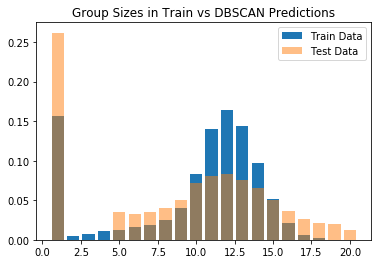

In [216]:
plt.bar(pd.value_counts(train_data['size'], normalize=True).sort_index().index, pd.value_counts(train_data['size'], normalize=True).sort_index().values, label="Train Data")
plt.bar(pd.value_counts(test_data['size'], normalize=True).sort_index().index, pd.value_counts(test_data['size'], normalize=True).sort_index().values, label="Test Data", alpha=0.5)
plt.title("Group Sizes in Train vs DBSCAN Predictions")
plt.legend()
plt.show()

In [ ]:
one_submission = create_one_event_submission(event_id, hits, labels)

In [212]:
test_data = pd.read_csv("1000data.csv")

test_data['size'] = test_data.groupby('predictions')['predictions'].transform('count')
test_data.loc[test_data.predictions == 0, 'size'] = 1
test_data.loc[test_data['size'] > 20, 'size'] = 1
hit_count = test_data['size'].values

In [215]:
for event_id in test_data.event_id.unique():
    hits = test_data[test_data.event_id == event_id]
    labels = test_data[test_data.event_id == event_id].predictions
    one_submission = create_one_event_submission(event_id, hits, labels)
    truth = pd.read_csv("./data/train_1/event00000"+str(event_id)+"-truth.csv")
    break
score = score_event(truth, one_submission)
score    

0.5145460151203362

In [214]:
test_data.loc[test_data['size'] < 2, 'predictions'] = 0

In [95]:
test_data['size'].describe()

count    575964.000000
mean          8.265433
std           4.490883
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          20.000000
Name: size, dtype: float64

/home/skooch/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


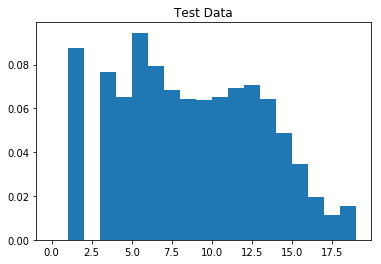

In [45]:
plt.hist(test_data['size'], bins=np.arange(0, 20, 1), normed=True)
plt.title("Test Data")
plt.show()

/home/skooch/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


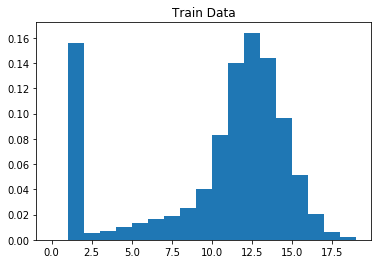

In [46]:
plt.hist(train_data['size'], bins=np.arange(0, 20, 1), normed=True)
plt.title("Train Data")
plt.show()

In [259]:
big_group_pids = hit_count[hit_count > 15]
big_group_filter = np.isin(train_data.particle_id, big_group_pids)
# big_groups = train_data[big_group_filter]
big_groups = train_data[train_data['size'] > 15]

small_group_pids = hit_count[hit_count <= 15]
small_group_filter = np.isin(train_data.particle_id, small_group_pids)
small_groups = train_data[train_data['size'] <= 15]

In [260]:
print("Groups > 15", len(big_group_pids))
print("Groups <= 15", len(small_group_pids))

Groups > 15 239967
Groups <= 15 7947772


In [261]:
big_groups[['x', 'y', 'z', 'x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1', 'size']].describe()

,x,y,z,x2,y2,z2,a0,a1,cosa1,sina1,size
count,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000
mean,2.360213,0.675520,8.516754,0.003211,0.002624,0.005120,-0.002746,0.981707,-0.005257,-0.004821,16.378198
std,237.583420,236.929886,1137.024658,0.313450,0.314875,0.895859,1.814825,2.663670,0.706655,0.707525,0.679998
min,-1025.290039,-1025.109985,-2955.500000,-0.999960,-0.999998,-0.999789,-3.141588,-3.132210,-1.000000,-1.000000,16.000000
25%,-59.642050,-61.499550,-702.500000,-0.086306,-0.089858,-0.988921,-1.568953,-1.033191,-0.714576,-0.714523,16.000000
50%,0.068255,-0.427959,0.746876,0.000104,-0.000617,0.008600,-0.008118,0.772311,-0.009020,-0.007890,16.000000
75%,61.730749,62.911699,711.400024,0.090502,0.093815,0.988258,1.571343,2.465490,0.695155,0.703696,17.000000
max,1025.170044,1025.219971,2955.500000,1.000000,0.999997,0.999785,3.141590,12.314260,1.000000,1.000000,20.000000


In [277]:
small_groups[['x', 'y', 'z', 'x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1', 'size']].describe()

,x,y,z,x2,y2,z2,a0,a1,cosa1,sina1,size
count,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06
mean,7.686771e-01,-1.471646e-02,2.915401e-01,1.268735e-03,-2.092988e-04,-2.314794e-04,-1.312986e-03,1.687868e+00,4.849422e-04,8.071866e-04,9.593429e+00
std,3.102179e+02,3.114612e+02,1.062030e+03,3.872704e-01,3.885462e-01,8.360932e-01,1.811363e+00,3.104579e+00,7.069108e-01,7.073022e-01,4.555010e+00
min,-1.025330e+03,-1.025340e+03,-2.955500e+03,-9.999990e-01,-9.999994e-01,-9.997995e-01,-3.141593e+00,-3.133096e+00,-1.000000e+00,-1.000000e+00,1.000000e+00
25%,-1.020530e+02,-1.032913e+02,-6.442000e+02,-1.796620e-01,-1.819155e-01,-9.306689e-01,-1.571245e+00,-6.269830e-01,-7.059760e-01,-7.071772e-01,8.000000e+00
50%,1.712210e-01,9.161160e-02,-1.281240e-01,2.985206e-04,1.576020e-04,-1.195998e-03,1.405130e-03,1.302153e+00,8.713165e-04,2.934773e-03,1.100000e+01
75%,1.034553e+02,1.034470e+02,6.426000e+02,1.816419e-01,1.820801e-01,9.302516e-01,1.567249e+00,3.093534e+00,7.074098e-01,7.078758e-01,1.300000e+01
max,1.025330e+03,1.025340e+03,2.955500e+03,9.999993e-01,9.999999e-01,9.997988e-01,3.141592e+00,1.231751e+01,1.000000e+00,1.000000e+00,1.500000e+01


In [278]:
big_groups[['x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1', 'size']].describe()

,x2,y2,z2,a0,a1,cosa1,sina1,size
count,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000
mean,0.003211,0.002624,0.005120,-0.002746,0.981707,-0.005257,-0.004821,16.378198
std,0.313450,0.314875,0.895859,1.814825,2.663670,0.706655,0.707525,0.679998
min,-0.999960,-0.999998,-0.999789,-3.141588,-3.132210,-1.000000,-1.000000,16.000000
25%,-0.086306,-0.089858,-0.988921,-1.568953,-1.033191,-0.714576,-0.714523,16.000000
50%,0.000104,-0.000617,0.008600,-0.008118,0.772311,-0.009020,-0.007890,16.000000
75%,0.090502,0.093815,0.988258,1.571343,2.465490,0.695155,0.703696,17.000000
max,1.000000,0.999997,0.999785,3.141590,12.314260,1.000000,1.000000,20.000000


In [279]:
small_groups[['x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1', 'size']].describe()

,x2,y2,z2,a0,a1,cosa1,sina1,size
count,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06
mean,1.268735e-03,-2.092988e-04,-2.314794e-04,-1.312986e-03,1.687868e+00,4.849422e-04,8.071866e-04,9.593429e+00
std,3.872704e-01,3.885462e-01,8.360932e-01,1.811363e+00,3.104579e+00,7.069108e-01,7.073022e-01,4.555010e+00
min,-9.999990e-01,-9.999994e-01,-9.997995e-01,-3.141593e+00,-3.133096e+00,-1.000000e+00,-1.000000e+00,1.000000e+00
25%,-1.796620e-01,-1.819155e-01,-9.306689e-01,-1.571245e+00,-6.269830e-01,-7.059760e-01,-7.071772e-01,8.000000e+00
50%,2.985206e-04,1.576020e-04,-1.195998e-03,1.405130e-03,1.302153e+00,8.713165e-04,2.934773e-03,1.100000e+01
75%,1.816419e-01,1.820801e-01,9.302516e-01,1.567249e+00,3.093534e+00,7.074098e-01,7.078758e-01,1.300000e+01
max,9.999993e-01,9.999999e-01,9.997988e-01,3.141592e+00,1.231751e+01,1.000000e+00,1.000000e+00,1.500000e+01


In [263]:
big_groups[['x', 'y', 'z', 'x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1']].describe() - small_groups[['x', 'y', 'z', 'x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1']].describe()

,x,y,z,x2,y2,z2,a0,a1,cosa1,sina1
count,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06
mean,1.591536e+00,6.902363e-01,8.225214e+00,1.942499e-03,2.833414e-03,5.351401e-03,-1.433142e-03,-7.061611e-01,-5.741805e-03,-5.627812e-03
std,-7.263448e+01,-7.453130e+01,7.499487e+01,-7.382038e-02,-7.367092e-02,5.976576e-02,3.461838e-03,-4.409089e-01,-2.558827e-04,2.232194e-04
min,3.991699e-02,2.299805e-01,0.000000e+00,3.868341e-05,1.609325e-06,1.001358e-05,4.768372e-06,8.857250e-04,0.000000e+00,0.000000e+00
25%,4.241095e+01,4.179170e+01,-5.829999e+01,9.335582e-02,9.205753e-02,-5.825190e-02,2.291977e-03,-4.062083e-01,-8.600459e-03,-7.345527e-03
50%,-1.029660e-01,-5.195706e-01,8.750000e-01,-1.943364e-04,-7.746176e-04,9.796068e-03,-9.523390e-03,-5.298418e-01,-9.890971e-03,-1.082476e-02
75%,-4.172450e+01,-4.053530e+01,6.880005e+01,-9.114030e-02,-8.826520e-02,5.800669e-02,4.093230e-03,-6.280442e-01,-1.225471e-02,-4.180267e-03
max,-1.599121e-01,-1.199951e-01,0.000000e+00,2.384186e-07,-3.039837e-06,-1.364946e-05,-1.668930e-06,-3.249168e-03,0.000000e+00,0.000000e+00


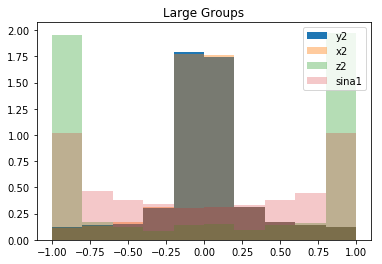

In [270]:
plt.hist(big_groups['y2'], label="y2", normed=True)
plt.hist(big_groups['x2'], label="x2", normed=True, alpha=0.4)
plt.hist(big_groups['z2'], label="z2", normed=True, alpha=0.35)
plt.hist(big_groups['sina1'], label="sina1", normed=True, alpha=0.25)
plt.legend()
plt.title("Large Groups")
plt.show()

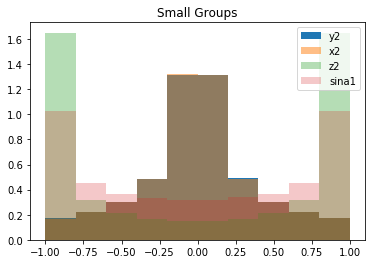

In [269]:
plt.hist(small_groups['y2'], label="y2", normed=True)
plt.hist(small_groups['x2'], label="x2", normed=True, alpha=0.5)
plt.hist(small_groups['z2'], label="z2", normed=True, alpha=0.35)
plt.hist(small_groups['sina1'], label="sina1", normed=True, alpha=0.25)
plt.title("Small Groups")
plt.legend()
plt.show()

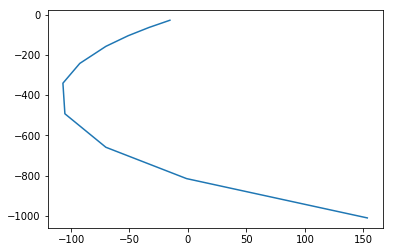

In [73]:
p_id = 49909    
p_id = 1110
p_id = 10
plt.plot(train_data[train_data.particle_id == p_id].sort_values("y").x, train_data[train_data.particle_id == p_id].sort_values("y").y)

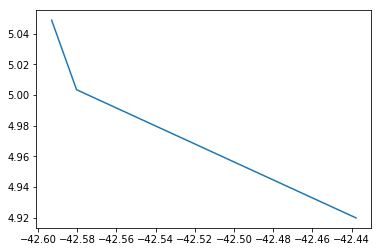

In [88]:
p_id = 3685064    
p_id = 19354287
p_id = 19354296
plt.plot(test_data[test_data.particle_id == p_id].sort_values("y").x, test_data[test_data.particle_id == p_id].sort_values("y").y)

In [91]:
test_data.sort_values("particle_id").head(30)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,size,r,rt,x2,y2,z2,a0,a1,sina1,cosa1
7958,7959,-40.0608,0.834435,-822.5,7,10,1,4,13,823.475448,40.069489,-0.048648,0.001013,-0.998815,3.120766,3.135127,0.006465,-0.999979
13677,13678,-34.1121,0.759301,-702.0,7,12,104,4,13,702.828722,34.120550,-0.048535,0.001080,-0.998821,3.119337,3.129795,0.011798,-0.999930
4,5,-73.5222,0.859165,-1502.5,7,2,1,4,13,1504.298010,73.527220,-0.048875,0.000571,-0.998805,3.129907,3.177727,-0.036127,-0.999347
5407,5408,-46.9493,0.894160,-962.5,7,8,1,4,13,963.644793,46.957814,-0.048721,0.000928,-0.998812,3.122550,3.142202,-0.000609,-1.000000
7885,7886,-46.6959,0.891465,-957.5,7,8,106,4,13,958.638384,46.704409,-0.048711,0.000930,-0.998812,3.122504,3.141947,-0.000354,-1.000000
10889,10890,-34.1296,0.749530,-702.5,7,12,1,4,13,703.328971,34.137829,-0.048526,0.001066,-0.998821,3.119635,3.130103,0.011490,-0.999934
13761,13762,-33.8998,0.737020,-697.5,7,12,106,4,13,698.323700,33.907811,-0.048545,0.001055,-0.998820,3.119855,3.130184,0.011408,-0.999935
3245,3246,-53.8759,0.950879,-1102.5,7,6,1,4,13,1103.816002,53.884291,-0.048809,0.000861,-0.998808,3.123945,3.149753,-0.008161,-0.999967
1440,1441,-73.2895,0.877932,-1497.5,7,2,106,4,13,1499.292624,73.294758,-0.048883,0.000586,-0.998804,3.129614,3.177134,-0.035534,-0.999368
5342,5343,-53.6325,0.935845,-1097.5,7,6,106,4,13,1098.810070,53.640664,-0.048810,0.000852,-0.998808,3.124145,3.149723,-0.008130,-0.999967


In [93]:
train_data.sort_values("particle_id", ascending=False).head(30)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,size,r,rt,x2,y2,z2,a0,a1,sina1,cosa1
35216,35217,-5.883920,-71.851997,87.126503,8,4,264,50328,4,113.085617,72.092514,-0.052031,-0.635377,0.770447,-1.652503,-1.606519,-0.999362,-0.035715
50698,50699,-19.651199,-169.692993,159.625000,8,8,720,50328,4,233.799103,170.827057,-0.084052,-0.725807,0.682744,-1.686087,-1.429936,-0.990096,0.140395
50702,50703,-20.321400,-171.580002,161.085007,8,8,721,50328,4,236.222427,172.779205,-0.086027,-0.726349,0.681921,-1.688684,-1.426663,-0.989631,0.143635
43061,43062,-7.192760,-116.052002,119.677002,8,6,429,50328,4,166.860382,116.274689,-0.043106,-0.695504,0.717228,-1.632696,-1.513699,-0.998370,0.057067
35184,35185,-27.259300,-68.159798,125.028999,8,4,263,50327,8,144.986481,73.408630,-0.188013,-0.470111,0.862349,-1.951244,-1.903577,-0.945138,-0.326673
51668,51669,-62.209400,-159.380997,293.066010,8,8,873,50327,8,339.352325,171.091537,-0.183318,-0.469662,0.863604,-1.942929,-1.685987,-0.993373,-0.114936
96729,96730,-107.142998,-344.126007,620.200012,13,4,908,50327,8,717.321716,360.419678,-0.149365,-0.479737,0.864605,-1.872631,-0.735874,-0.671236,0.741244
35154,35155,-26.531300,-66.473900,121.871002,8,4,262,50327,8,141.333755,71.572960,-0.187721,-0.470333,0.862292,-1.950547,-1.905218,-0.944600,-0.328223
104523,104524,-120.846001,-486.584991,864.599976,13,6,1421,50327,8,999.450745,501.366821,-0.120912,-0.486852,0.865075,-1.814227,0.383754,0.374404,0.927266
135978,135979,-80.801598,-855.747986,1494.500000,18,4,24,50327,8,1724.054443,859.554260,-0.046867,-0.496358,0.866852,-1.664939,4.790101,-0.996982,0.077633


In [358]:
p_id = 49909
train_data[train_data.particle_id == p_id]

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,size,r,rt,x2,y2,z2,a0,a1,sina1,cosa1,hit_count
27743,27744,-31.582899,7.132900,92.232697,8,2,144,49909,16,97.750847,32.378353,-0.323096,0.072970,0.943549,2.919472,2.928903,0.211089,-0.977467,11.0
36538,36539,-69.890701,12.930100,207.779007,8,4,319,49909,16,219.599670,71.076698,-0.318264,0.058880,0.946172,2.958657,3.003363,0.137790,-0.990461,5.0
37021,37022,-70.384499,12.976400,209.356995,8,4,351,49909,16,221.252609,71.570694,-0.318118,0.058650,0.946235,2.959275,3.004601,0.136564,-0.990631,3.0
37026,37027,-72.156601,13.163800,214.591995,8,4,352,49909,16,226.780914,73.347534,-0.318178,0.058046,0.946252,2.961143,3.008731,0.132471,-0.991187,12.0
45091,45092,-114.059998,15.877800,339.204010,8,6,623,49909,16,358.219421,115.159836,-0.318408,0.044324,0.946917,3.003276,3.120012,0.021579,-0.999767,6.0
89265,89266,-256.192993,0.814490,766.000000,13,2,681,49909,16,807.707581,256.194305,-0.317185,0.001008,0.948363,3.138413,3.713427,-0.541176,-0.840910,13.0
89563,89564,-259.221008,0.060439,774.799988,13,2,721,49909,16,817.013184,259.221008,-0.317279,0.000074,0.948332,3.141360,3.730013,-0.555048,-0.831818,3.0
89793,89794,-265.855988,-1.673730,795.599976,13,2,760,49909,16,838.845337,265.861267,-0.316931,-0.001995,0.948447,-3.135297,-2.516158,-0.585449,-0.810709,12.0
111543,111544,-395.899994,-56.676498,1221.500000,14,2,6,49909,16,1285.305908,399.936279,-0.308020,-0.044096,0.950357,-2.999400,-1.600091,-0.999571,-0.029291,12.0
113223,113224,-471.325012,-111.600998,1504.500000,14,4,9,49909,16,1580.544922,484.357361,-0.298204,-0.070609,0.951887,-2.909093,-0.857577,-0.756260,0.654272,10.0


In [254]:
train_data.groupby("particle_id").z2.std().describe()

count    4.723000e+04
mean     3.955753e-02
std      1.109142e-01
min      4.214685e-08
25%      1.382688e-04
50%      3.418009e-03
75%      2.620135e-02
max      1.381344e+00
Name: z2, dtype: float64

In [286]:
test_data.sort_values("predictions").predictions.unique()[:50]

array([   0,   55,   56,   61,  140,  175,  177,  228,  232,  240,  286,
        315,  390,  396,  423,  425,  429,  443,  466,  494,  495,  497,
        499,  573,  578,  594,  625,  629,  652,  657,  674,  676,  706,
        710,  749,  768,  793,  831,  849,  876,  878,  879,  881,  906,
        911,  958,  982,  993,  994, 1003])

In [283]:
test_data[(test_data.predictions <= 1028835) & (test_data.predictions != 0)].count()

Unnamed: 0      7911
hit_id          7911
x               7911
y               7911
z               7911
volume_id       7911
layer_id        7911
module_id       7911
s1              7911
N1              7911
stepped_z       7911
e1              7911
group_locked    7911
r               7911
rt              7911
a0              7911
z1              7911
z2              7911
x2              7911
y2              7911
z3              7911
a1              7911
sina1           7911
cosa1           7911
s2              7911
e2              7911
N2              7911
particle_id     7911
predictions     7911
event_id        7911
size            7911
dtype: int64

In [265]:
train_data.sort_values("particle_id").particle_id.unique()[:50]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [275]:
train_data[(train_data.particle_id <= 1003) & (train_data.particle_id != 0)].count()

hit_id         9772
x              9772
y              9772
z              9772
volume_id      9772
layer_id       9772
module_id      9772
particle_id    9772
size           9772
r              9772
rt             9772
x2             9772
y2             9772
z2             9772
a0             9772
a1             9772
sina1          9772
cosa1          9772
dtype: int64

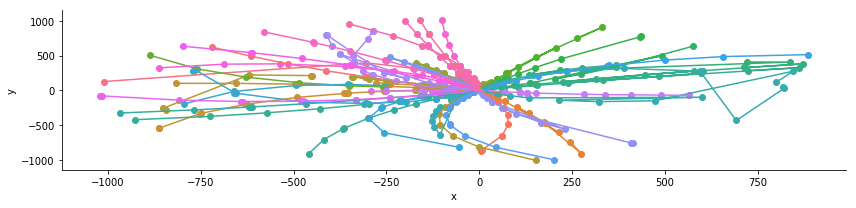

In [258]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 49) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x', 'y')
fg.map(plt.plot, 'x', 'y')

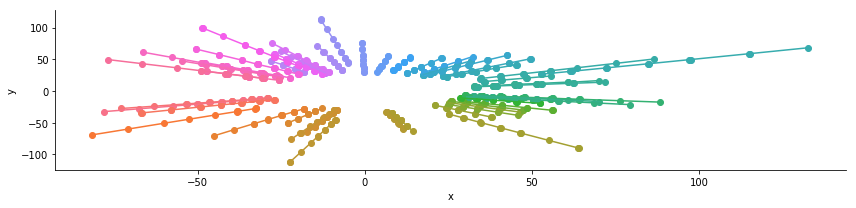

In [287]:
fg = sns.FacetGrid(data=test_data[(test_data.predictions <= 1003) & (test_data['size'].values > 1)], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x', 'y')
fg.map(plt.plot, 'x', 'y')

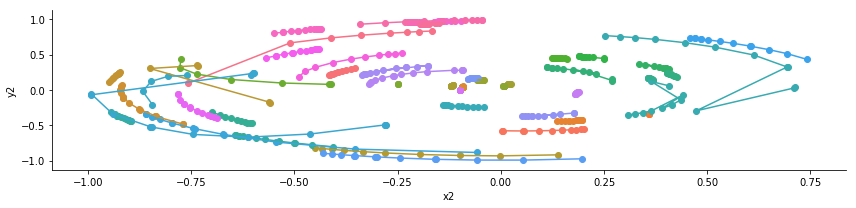

In [259]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 49) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'y2')
fg.map(plt.plot, 'x2', 'y2')

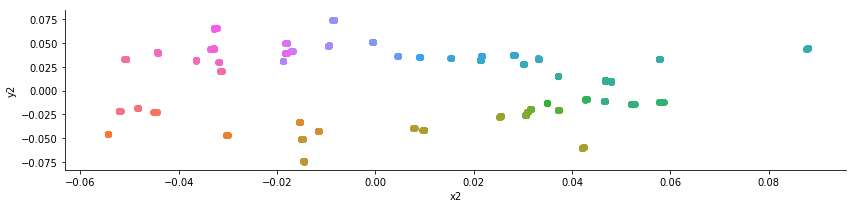

In [235]:
fg = sns.FacetGrid(data=test_data[(test_data.predictions <= 1003) & (test_data['size'].values > 1)], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x2', 'y2')
fg.map(plt.plot, 'x2', 'y2')

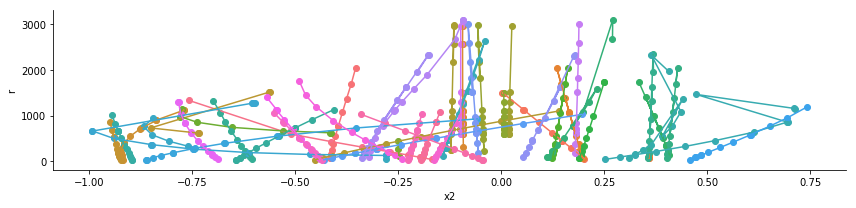

In [260]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 49) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'r')
fg.map(plt.plot, 'x2', 'r')

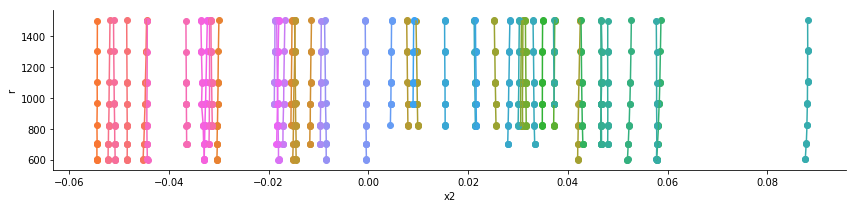

In [236]:
fg = sns.FacetGrid(data=test_data[(test_data.predictions <= 1003) & (test_data['size'].values > 1)], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x2', 'r')
fg.map(plt.plot, 'x2', 'r')

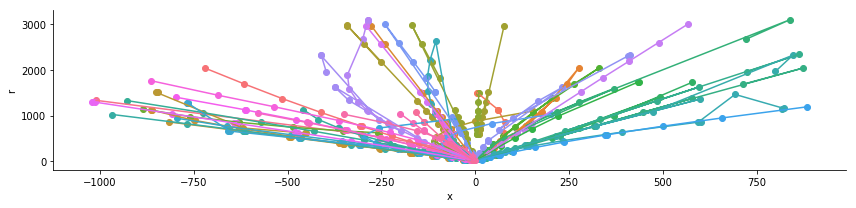

In [261]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 49) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x', 'r')
fg.map(plt.plot, 'x', 'r')

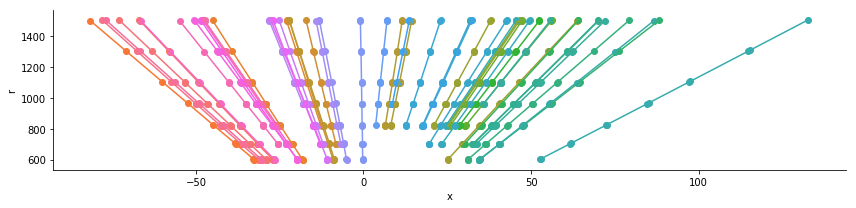

In [237]:
fg = sns.FacetGrid(data=test_data[(test_data.predictions <= 1003) & (test_data['size'].values > 1)], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x', 'r')
fg.map(plt.plot, 'x', 'r')

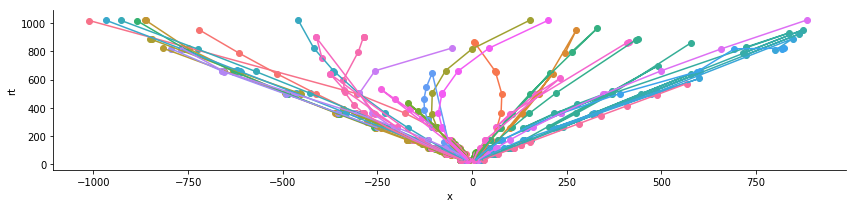

In [63]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x', 'rt')
fg.map(plt.plot, 'x', 'rt')

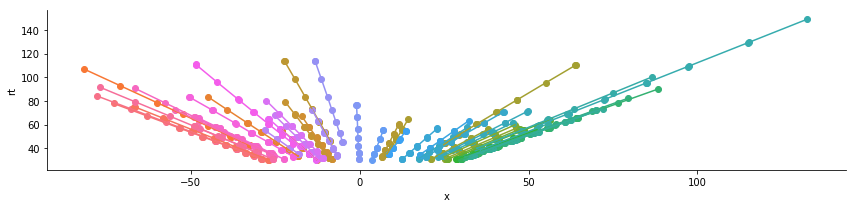

In [238]:
fg = sns.FacetGrid(data=test_data[(test_data.predictions <= 1003) & (test_data['size'].values > 1)], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x', 'rt')
fg.map(plt.plot, 'x', 'rt')

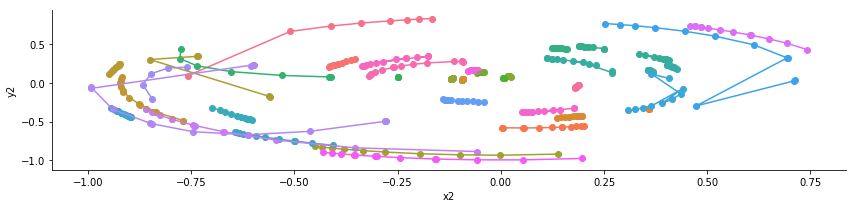

In [67]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'y2')
fg.map(plt.plot, 'x2', 'y2')

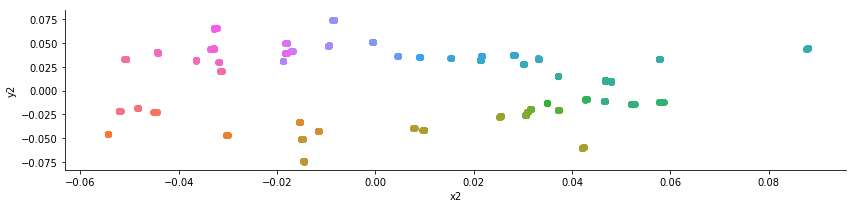

In [239]:
fg = sns.FacetGrid(data=test_data[(test_data.predictions <= 1003) & (test_data['size'].values > 1)], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x2', 'y2')
fg.map(plt.plot, 'x2', 'y2')

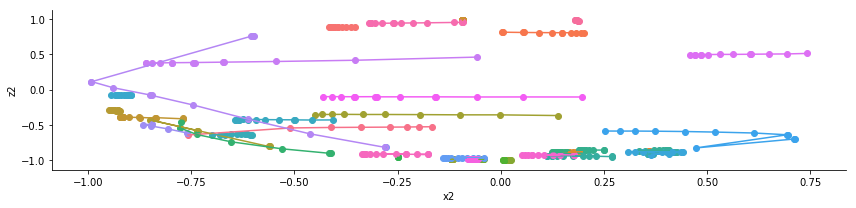

In [68]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'z2')
fg.map(plt.plot, 'x2', 'z2')

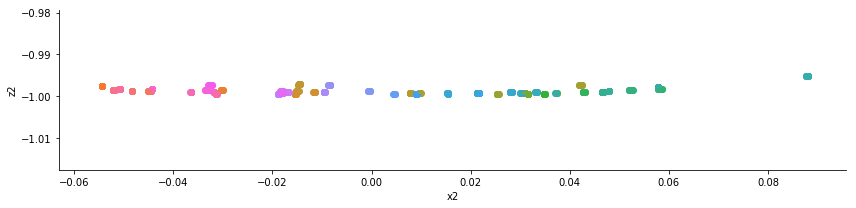

In [240]:
fg = sns.FacetGrid(data=test_data[(test_data.predictions <= 1003) & (test_data['size'].values > 1)], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x2', 'z2')
fg.map(plt.plot, 'x2', 'z2')

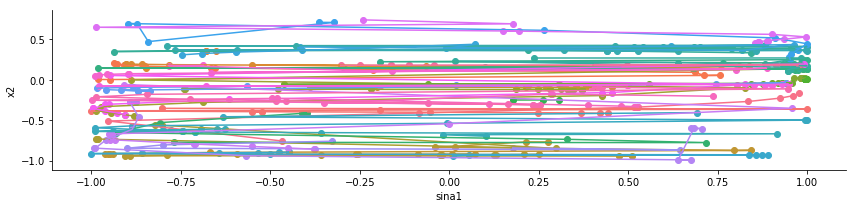

In [70]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'sina1', 'x2')
fg.map(plt.plot, 'sina1', 'x2')

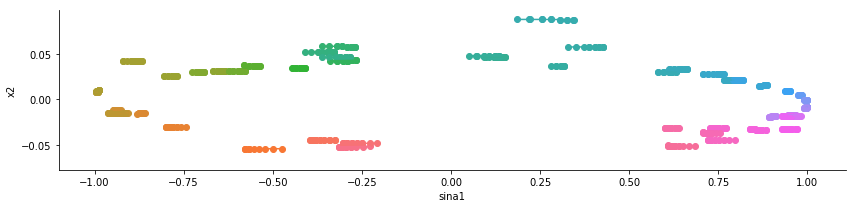

In [242]:
fg = sns.FacetGrid(data=test_data[(test_data.predictions <= 1003) & (test_data['size'].values > 1)], hue='predictions', aspect=4)
fg.map(plt.scatter, 'sina1', 'x2')
fg.map(plt.plot, 'sina1', 'x2')

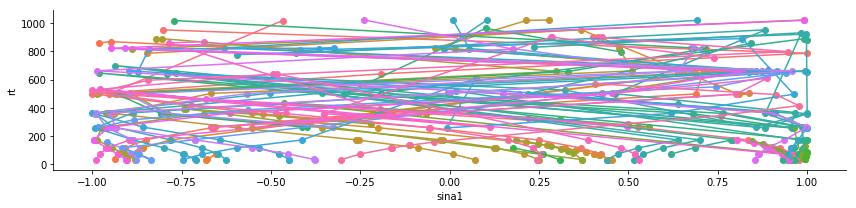

In [252]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'sina1', 'rt')
fg.map(plt.plot, 'sina1', 'rt')

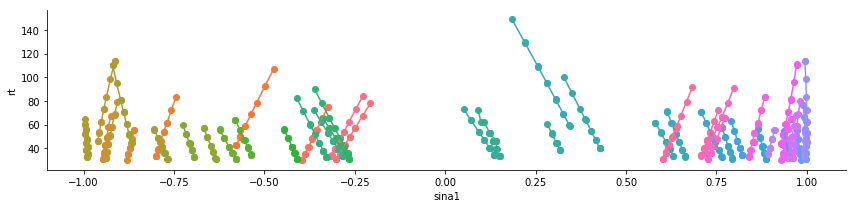

In [288]:
fg = sns.FacetGrid(data=test_data[(test_data.predictions <= 1003) & (test_data['size'].values > 1)], hue='predictions', aspect=4)
fg.map(plt.scatter, 'sina1', 'rt')
fg.map(plt.plot, 'sina1', 'rt')

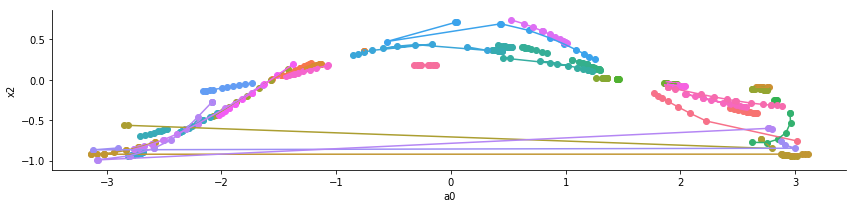

In [295]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'a0', 'x2')
fg.map(plt.plot, 'a0', 'x2')

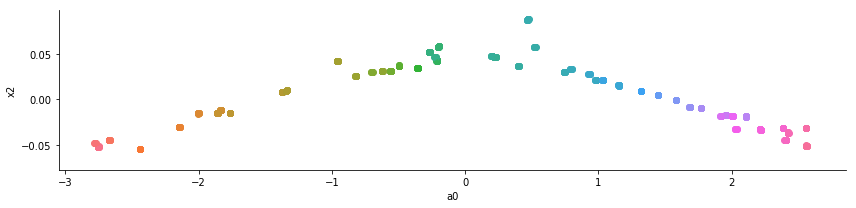

In [296]:
fg = sns.FacetGrid(data=test_data[(test_data.predictions <= 1003) & (test_data['size'].values > 1)], hue='predictions', aspect=4)
fg.map(plt.scatter, 'a0', 'x2')
fg.map(plt.plot, 'a0', 'x2')

Then, train the classifier using this sample. Notice that data preprocessing is included into the training procedure.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

class Clusterer(object):
    
    def __init__(self):
        self.classifier = None
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    def fit(self, hits):
        
        X = self._preprocess(hits)
        y = hits.particle_id.values
        
        self.classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
        self.classifier.fit(X, y)
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        labels = self.classifier.predict(X)
        
        return labels

In [7]:
model = Clusterer()
model.fit(train_data)

### Test

Use the trained classifier to predict labels of hits in a new event.

In [8]:
path_to_event = os.path.join(path_to_train, "event0000{:05d}".format(start_event_id + n_train_samples + 1))
hits, cells, particles, truth = load_event(path_to_event)

In [9]:
%%time
# Warning: it takes about 30s per one event
labels = model.predict(hits)

CPU times: user 23.4 s, sys: 10.6 ms, total: 23.4 s
Wall time: 19 s


# Score

Calculate quality of the track pattern recognition for one event.

In [10]:
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [11]:
print("Your score: ", score)

Your score:  0.09900948072230796


# Recognize tracks in all events of a dataset

In this example, the dataset is the whole training set. This may take a very long time. To run on only a subset, use

     load_dataset(path_to_train, skip=1000, nevents=5)

It will skip the first 1000 events, and select the next 5 ones.

**Warning:** it takes about 30s per one event

In [33]:
dataset_submissions = []
dataset_scores = []

for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=5):
        
    # Track pattern recognition
    labels = model.predict(hits)
        
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)
    
    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)
    
    print("Score for event %d: %.3f" % (event_id, score))
    
print('Mean score: %.3f' % (np.mean(dataset_scores)))

Score for event 1010: 0.065
Score for event 1011: 0.068
Score for event 1012: 0.065
Score for event 1013: 0.078
Score for event 1014: 0.086
Mean score: 0.073


# Submission

Create a submission file.

**Warning:** it takes about 30s per one event

In [ ]:
path_to_test = "data/test"
test_dataset_submissions = []

create_submission = True

if create_submission:
    for event_id, hits, cells in load_dataset(path_to_test, parts=['hits', 'cells']):

        # Track pattern recognition
        labels = model.predict(hits)

        # Prepare submission for an event
        one_submission = create_one_event_submission(event_id, hits, labels)
        test_dataset_submissions.append(one_submission)
        
        print('Event ID: ', event_id)

    # Create submission file
    submission = pd.concat(test_dataset_submissions, axis=0)
    submission.to_csv('20180626_submission_3.csv.gz', index=False, compression='gzip')

Event ID:  0
Event ID:  1
Event ID:  2
Event ID:  3
Event ID:  4
Event ID:  5
Event ID:  6
Event ID:  7
Event ID:  8
Event ID:  9
Event ID:  10
Event ID:  11
Event ID:  12
Event ID:  13
Event ID:  14
Event ID:  15
Event ID:  16
Event ID:  17
Event ID:  18
Event ID:  19
Event ID:  20
Event ID:  21
Event ID:  22
Event ID:  23
Event ID:  24
Event ID:  25
Event ID:  26
Event ID:  27
Event ID:  28
Event ID:  29
Event ID:  30
Event ID:  31
Event ID:  32
Event ID:  33
Event ID:  34
Event ID:  35
Event ID:  36
Event ID:  37
Event ID:  38
Event ID:  39
Event ID:  40
Event ID:  41
Event ID:  42
Event ID:  43
Event ID:  44
Event ID:  45
Event ID:  46
Event ID:  47
Event ID:  48
Event ID:  49
